In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
"""flags, file path, and file names for saving data and figures"""

# have data file already?
have_data_file = False  # if True, load data from file
                        # if False, run simulation (and save data)

if have_data_file:
    # load data from this path (including file name)
    data_path = 'YOUR LOCAL DIRECTORY WHERE DATA FILE IS ALREADY SAVED'
else:
    # save simulated data?
    save_data = False
    # file name for new simulated data to be saved
    filename_data = 'data-cue-shift_yyyy-mm-dd.npz'

# save simulated data and/or figure panel(s) to this path (excluding file name)
save2path = 'YOUR LOCAL DIRECTORY FOR SAVING FILES'

# save figure panel 4f?
save_fig4f = False
# save figure panel 4g?
save_fig4g = False
# figure panel file format, e.g. 'pdf', 'eps', 'svg'
fig_format = 'pdf'
# figure panel file names
filename_fig4f = 'fig4f-cue-shift_yyyy-mm-dd'
filename_fig4g = 'fig4g-cue-shift_yyyy-mm-dd'

In [3]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.stats
from scipy.ndimage import gaussian_filter
from scipy.ndimage import gaussian_filter1d
from tqdm import tqdm
from ra_network import RingAttractorNetwork, \
    back_to_circ, movmean, plot_all, sliding_window, offset_variation, \
        generate_ground_truth, generate_ER_input, generate_AV_input_noise, generate_ER_input_noise

In [4]:
# plotting parameters

mpl.rcParams.update({
    'axes.labelsize': 20,
    'axes.titlesize': 20,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 16
    })

%matplotlib inline

In [5]:
# ring attractor network parameters

network_params = {
    'N' : 32,                               # number of neurons
    'tau': 0.05,                            # network time constant [s]
    'alpha': -8.93,                         # self-excitation parameter
    'D' : 5.19,                             # nearest-neighbor excitation
    'beta' : 0.11,                          # global inhibition parameter
    'f_act' : lambda x: np.maximum(0,x+1),  # activation function
    'v_rel' : 3.64 ,                        # angular velocity conversion factor
    'dt' : 0.0025                           # step size [s]
    }

In [6]:
def calc_cue_shift(dt, cue_shift_magnitude, T_cue_shift, n_cue_shifts):
    """compute shift in angular position of cue to be added to ground truth head direction (HD)
    Args:
        dt: (float) simulation step size [s]
        cue_shift_magnitude: (float) magnitude of cue shift [radian]
        T_cue_shift: (float) interval between cue shifts [s]
        n_cue_shifts: (int) number of cue shifts
    Returns:
        z_cue_shift: (np.ndarray of shape (n_timesteps_cue_shift * n_cue_shifts,))
            shift in angular position of cue at each time step [radian]
        cue_shifts_array: (np.ndarray of shape (n_cue_shifts,)) array of cue shifts [radian]
        cumulative_shifts_array: (np.ndarray of shape (n_cue_shifts,))
            array of cumulative cue shifts [radian]
    """

    # number of time steps between cue shifts
    n_timesteps_cue_shift = int(T_cue_shift / dt)

    # array of random (clockwise or counterclockwise) cue shifts of fixed magnitude of shape (n_cue_shifts,)
    cue_shifts_array = cue_shift_magnitude * np.random.choice(np.array([-1, 1]), n_cue_shifts)

    # array of cumulative cue shifts of shape (n_cue_shifts,)
    cumulative_shifts_array = np.cumsum(cue_shifts_array)

    # array of cumulative cue shifts to be applied at each time step of shape (n_timesteps,)
    z_cue_shift = np.repeat(cumulative_shifts_array, n_timesteps_cue_shift)

    return z_cue_shift, cue_shifts_array, cumulative_shifts_array


def calc_offset(phi1, phi2):
    """compute angular offset between two arrays of the same shape
    Args:
        phi1: (1-dimensional np.ndarray) first array of angles [radian]
        phi2: (1-dimensional np.ndarray) second array of angles [radian]
    Returns:
        offset: (1-dimensional np.ndarray) offset [0, pi) between phi1 and phi2 [radian]
    """

    offset = np.minimum(np.abs(phi1 - phi2), 2*np.pi - np.abs(phi1 - phi2))

    return offset


def calc_offset_change(dt, t_shift, window, bump_pos, cue_pos):
    """compute change in cue offset
    Args:
        dt: (float) simulation step size [s]
        t_shift: (float) time at which cue shifts [s]
        window: (float) number of time steps before or after cue shift for computing offset [step]
        bump_pos: (np.ndarray array of shape (int(T_burn_in / ra.dt) + n_timesteps,)) bump position across time
        cue_pos: (np.ndarray array with same shape as bump_pos) cue position across time
    Returns:
        offset_change: (float) change in cue offset [-pi, pi) [radian]
    """

    tstep_shift = int(t_shift / dt)     # time step at which cue shifts [step]
    tstep_prior = tstep_shift - window  # time step at which window prior to cue shift begins 
    tstep_after = tstep_shift + window  # time step at which window after cue shift ends

    bump_pos_prior = bump_pos[tstep_prior:tstep_shift]  # bump positions prior to cue shift
    bump_pos_after = bump_pos[tstep_shift:tstep_after]  # bump positions after cue shift

    cue_pos_prior = cue_pos[tstep_prior:tstep_shift]    # cue positions prior to cue shift
    cue_pos_after = cue_pos[tstep_shift:tstep_after]    # cue positions after cue shift

    offset_prior = calc_offset(bump_pos_prior, cue_pos_prior)   # compute cue offset prior to cue shift
    offset_prior = np.mean(offset_prior)                        # average over time window

    offset_after = calc_offset(bump_pos_after, cue_pos_after)   # compute cue offset after cue shift
    offset_after = np.mean(offset_after)                        # average over time window

    offset_change = offset_after - offset_prior         # change in cue offset

    return offset_change


def calc_bump_pref_index(offset_change_visual, offset_change_wind):
    """compute bump preference index
    Args:
        offset_change_visual: change in visual cue offset [-pi, pi) [radian]
        offset_change_wind: change in wind cue offset [-pi, pi) [radian]
    Returns:
        bump_pref_index: 1 corresponds to wind preference, -1 corresponds to visual preference
    """

    bump_pref_index = (np.abs(offset_change_visual) - np.abs(offset_change_wind)) \
        / (np.abs(offset_change_visual) + np.abs(offset_change_wind))

    return bump_pref_index

In [7]:
"""specify simulation parameters"""

# number of simulation runs
n_sims = 4 * 3      # should be a multiple of 4 to account for all conditions:
                    # condition 1: visual cue is presented first; visual ER amplitude is fixed
                    # condition 2: visual cue is presented first; wind ER amplitude is fixed
                    # condition 3: wind cue is presented first; visual ER amplitude is fixed
                    # condition 4: wind cue is presented first; wind ER amplitude is fixed
    
# ER input parameter
ER_amplitude_scale_fixed =  0.75                                  # ER amplitude of fixed cue
ER_amplitude_scale_varied_array = np.arange(0.5, 1.05, 0.05)      # ER amplitudes of varied cue

# number of ER amplitudes associated with wind cue
n_params = len(ER_amplitude_scale_varied_array)

# specify gamma decay parameter
gamma_decay = 17

# cue shift magnitude
cue_shift_magnitude = 120             # [deg]
cue_shift_magnitude *= np.pi / 180    # [rad]

# simulation time parameters
T_burn_in = 30          # burn-in period when cues are off [s]
T_cue_1_init = 25       # length of initial block when only cue 1 is on [s]
T_cue_2_init = 25       # length of initial block when only cue 2 is on [s]
T_both_cues = 262.5     # length of block when both cues are on [s]
T_cue_shift = 12.5      # length of interval between cue shifts [s]

T = T_cue_1_init + T_cue_2_init + T_both_cues           # total length of simulation excluding burn-in [s]
n_cue_shifts = int(T_both_cues / T_cue_shift) - 1       # number of cue shifts

# time points in simulation
t_cue_1_onset_init = T_burn_in                                                              # onset of cue 1 only block [s]
t_cue_2_onset_init = t_cue_1_onset_init + T_cue_1_init                                      # onset of cue 2 only block [s]
t_both_cues_onset = t_cue_2_onset_init + T_cue_2_init                                       # onset of two-cue block [s]
t_cue_1_shifts_array = t_both_cues_onset + T_cue_shift * np.arange(1, n_cue_shifts + 1, 2)  # time points when cue 1 shifts [s]
t_cue_2_shifts_array = t_both_cues_onset + T_cue_shift * np.arange(2, n_cue_shifts + 1, 2)  # time points when cue 2 shifts [s]
t_cue_shifts_array = t_both_cues_onset + T_cue_shift * np.arange(1, n_cue_shifts + 1)       # time points when one cue shifts [s]

n_cue_1_shifts = len(t_cue_1_shifts_array)              # number of times when cue 1 shifts
n_cue_2_shifts = len(t_cue_2_shifts_array)              # number of times when cue 2 shifts

# time intervals to analyze (test) bump parameters and offset variability
T_cue_1_test = T_cue_1_init / 2     # use second half of cue 1 only block
T_cue_2_test = T_cue_2_init / 2     # use second half of cue 2 only blok
T_test = 5                          # length of interval before and after cue shift for testing [s]

# ER input noise parameters
ER_baseline_factor = 0.45

# specify window size for computing offset variability
windowsize_offset_variability = 3200  # [steps], equivalent to 8 [s] in simulation

# specify initial weight norm
W_norm_init = 1.5

# in the first half of the simulation runs, fixed cue presented before varied cue
# in the second half of the simulation runs, varied cue is presented before fixed cue
fixed_cue_before_varied_cue = np.concatenate((np.ones(int(n_sims/2)), np.zeros(n_sims - int(n_sims/2))))

In [8]:
"""create ring attractor object"""

ra = RingAttractorNetwork(network_params)

# learning rule parameters associated with cue 1
ra.gamma_Hebb = 1
ra.gamma_postboost = 1
ra.gamma_decay = gamma_decay

# learning rule parameters associated with cue 2
ra.gamma_Hebb_2 = 1
ra.gamma_postboost_2 = 1
ra.gamma_decay_2 = gamma_decay

# learning rate
ra.eta = 5e-5

h0, w0 = ra.determine_features_basic()
ER_baseline = ER_baseline_factor * np.sum(ra.r_init)

# number of time steps in simulation excluding burn-in
n_timesteps = int(T / ra.dt)

# number of time steps between cue shifts
n_timesteps_cue_shift = int(T_cue_shift / ra.dt)

# number of time steps in testing periods
n_timesteps_cue_1_test = int(T_cue_1_test / ra.dt)
n_timesteps_cue_2_test = int(T_cue_2_test / ra.dt)
n_timesteps_test = int(T_test / ra.dt)

In [9]:
"""simulation"""

if have_data_file == False:

    # initialize data arrays
    offset_variability_cue_1_array = np.full((n_sims, n_params), np.nan)
    offset_variability_cue_2_array = np.full((n_sims, n_params), np.nan)

    bump_width_cue_1_array = np.full((n_sims, n_params), np.nan)
    bump_width_cue_2_array = np.full((n_sims, n_params), np.nan)

    bump_amplitude_cue_1_array = np.full((n_sims, n_params), np.nan)
    bump_amplitude_cue_2_array = np.full((n_sims, n_params), np.nan)

    z_cue_1_array = np.full((n_sims, n_params, int((T_burn_in + T) / ra.dt)), np.nan)
    z_cue_2_array = np.full((n_sims, n_params, int((T_burn_in + T) / ra.dt)), np.nan)

    bump_pos_array = np.full((n_sims, n_params, int((T_burn_in + T) / ra.dt)), np.nan)

    ER_amplitude_fixed_array = np.full((n_sims, n_params), np.nan)
    ER_amplitude_varied_array = np.full((n_sims, n_params), np.nan)

    for i_sim in range(n_sims):
        for i_param, ER_amplitude_scale_varied in enumerate(tqdm(ER_amplitude_scale_varied_array)):
            # generate ground truth AV input and HD for learning
            v_AV, z_HD = generate_ground_truth(ra.dt, T_burn_in + T)

            # compute shift in cue 1 to be applied at each time step during two-cue block
            # shape (n_timesteps_cue_shift * n_cue_shifts,)
            z_cue_1_shift, _, _ = calc_cue_shift(ra.dt, cue_shift_magnitude, 2 * T_cue_shift, int(n_cue_shifts / 2))

            # compute shift in cue 2 to be applied at each time step during two-cue block
            # shape (n_timesteps_cue_shift * (n_cue_shifts - 1),)
            z_cue_2_shift, _, _ = calc_cue_shift(ra.dt, cue_shift_magnitude, 2 * T_cue_shift, int(n_cue_shifts / 2))
            z_cue_2_shift = z_cue_2_shift[:-n_timesteps_cue_shift]       # cue 1 and 2 alternate

            # compute angular position of cue 1
            z_cue_1 = np.copy(z_HD)
            z_cue_1[-len(z_cue_1_shift):] = z_HD[-len(z_cue_1_shift):] + z_cue_1_shift
            
            # compute angular position of cue 2
            z_cue_2 = np.copy(z_HD)
            z_cue_2[-len(z_cue_2_shift):] = z_HD[-len(z_cue_2_shift):] + z_cue_2_shift

            # store cue positions
            z_cue_1_array[i_sim, i_param, :] = z_cue_1
            z_cue_2_array[i_sim, i_param, :] = z_cue_2

            # generate AV input noise
            noise_AV = generate_AV_input_noise(ra.dt, T_burn_in + T)

            # determine random initialization for weight matrix
            W_init = np.random.uniform(0, 1, (ra.N, ra.N))
            W_init = W_norm_init * W_init / np.linalg.norm(W_init)

            # determine whether fixed cue precedes varied cue
            if fixed_cue_before_varied_cue[i_sim] == 1:
                # fixed cue precedes varied cue, i.e. fixed cue is cue 1 and varied cue is cue 2
                g1, _, ER_amplitude_fixed = generate_ER_input(ra, T_burn_in + T, v_AV, z_cue_1, h_scale=ER_amplitude_scale_fixed)
                g2, _, ER_amplitude_varied = generate_ER_input(ra, T_burn_in + T, v_AV, z_cue_2, h_scale=ER_amplitude_scale_varied)
            else:
                # varied cue precedes fixed cue, i.e. varied cue is cue 1 and fixed cue is cue 2
                g1, _, ER_amplitude_varied = generate_ER_input(ra, T_burn_in + T, v_AV, z_cue_1, h_scale=ER_amplitude_scale_varied)
                g2, _, ER_amplitude_fixed = generate_ER_input(ra, T_burn_in + T, v_AV, z_cue_2, h_scale=ER_amplitude_scale_fixed)

            # store ER amplitudes
            ER_amplitude_fixed_array[i_sim, i_param] = ER_amplitude_fixed
            ER_amplitude_varied_array[i_sim, i_param] = ER_amplitude_varied

            # generate ER input noise associated with cue 1
            noise_g1 = generate_ER_input_noise(g1)              # generate uniform input noise
            noise_g1 = noise_g1.T / np.sum(noise_g1, axis=1)    # normalize by sum, shape (ra.N, int(T/ra.dt))
            noise_g1 = ER_baseline * noise_g1                   # scale by constant ER baseline, independent of ER activity
            noise_g1 = noise_g1.T                               # shape (int(T/ra.dt), ra.N)

            # generate ER input noise associated with cue 2
            noise_g2 = generate_ER_input_noise(g2)
            noise_g2 = noise_g2.T / np.sum(noise_g2, axis=1)
            noise_g2 = ER_baseline * noise_g2
            noise_g2 = noise_g2.T

            # turn off ER input when associated cue is off
            g1[:int(t_cue_1_onset_init / ra.dt)] = 0                                    # cue 1 is off in burn-in period
            g2[:int(t_cue_2_onset_init / ra.dt)] = 0                                    # cue 2 is off in burn-in and initial cue 1 block
            g1[int(t_cue_2_onset_init / ra.dt) : int(t_both_cues_onset / ra.dt)] = 0    # cue 1 is off in initial cue 2 block


            """simulation"""

            # reset network activity
            ra.reset_network()

            # initialize weight matrices
            ra.W = np.copy(W_init)
            ra.W2 = np.copy(W_init)

            # run simulation
            ra.simulate_two_cues(T_burn_in + T, v = v_AV + noise_AV, g = g1 + noise_g1, g2 = g2 + noise_g2, learn=True, trace=True)

            # extract bump position
            bump_pos = ra.determine_bumpPosition(ydata = ra.r_trace)
            bump_pos_array[i_sim, i_param, :] = bump_pos

            # initialize temporary data arrays
            offset_variability_vs_t_cue_1 = np.full((n_timesteps_cue_1_test), np.nan)
            offset_variability_vs_t_cue_2 = np.full((n_timesteps_cue_2_test), np.nan)
            bump_width_vs_t_cue_1 = np.full((n_timesteps_cue_1_test), np.nan)
            bump_width_vs_t_cue_2 = np.full((n_timesteps_cue_2_test), np.nan)
            bump_amplitude_vs_t_cue_1 = np.full((n_timesteps_cue_1_test), np.nan)
            bump_amplitude_vs_t_cue_2 = np.full((n_timesteps_cue_2_test), np.nan)

            # second half of cue 1 only block
            for t_step in range(n_timesteps_cue_1_test):
                idx = int(t_cue_2_onset_init / ra.dt) - t_step - 1

                # extract bump parameters
                bump_amplitude_vs_t_cue_1[t_step], bump_width_vs_t_cue_1[t_step] = ra.determine_features_basic(ind=idx)

                # compute offset variability
                window_bump_pos = sliding_window(bump_pos, idx, windowsize_offset_variability)
                window_z = sliding_window(z_HD, idx, windowsize_offset_variability)
                offset_variability_vs_t_cue_1[t_step] = offset_variation(window_bump_pos, window_z)

            # second half of cue 2 only block
            for t_step in range(n_timesteps_cue_2_test):
                idx = int(t_both_cues_onset / ra.dt) - t_step - 1

                # extract bump parameters
                bump_amplitude_vs_t_cue_2[t_step], bump_width_vs_t_cue_2[t_step] = ra.determine_features_basic(ind=idx)

                # compute offset variability
                window_bump_pos = sliding_window(bump_pos, idx, windowsize_offset_variability)
                window_z = sliding_window(z_HD, idx, windowsize_offset_variability)
                offset_variability_vs_t_cue_2[t_step] = offset_variation(window_bump_pos, window_z)

            # compute steady-state values in second half of cue 1 only block
            offset_variability_cue_1_array[i_sim, i_param] = np.mean(offset_variability_vs_t_cue_1)
            bump_width_cue_1_array[i_sim, i_param] = np.mean(bump_width_vs_t_cue_1)
            bump_amplitude_cue_1_array[i_sim, i_param] = np.mean(bump_amplitude_vs_t_cue_1)

            # compute steady-state values in second half of cue 2 only block
            offset_variability_cue_2_array[i_sim, i_param] = np.mean(offset_variability_vs_t_cue_2)
            bump_width_cue_2_array[i_sim, i_param] = np.mean(bump_width_vs_t_cue_2)
            bump_amplitude_cue_2_array[i_sim, i_param] = np.mean(bump_amplitude_vs_t_cue_2)


    # compute HD encoding accuracy from offset variability
    HD_encoding_accuracy_cue_1_array = 1 - offset_variability_cue_1_array
    HD_encoding_accuracy_cue_2_array = 1 - offset_variability_cue_2_array

100%|██████████| 11/11 [02:43<00:00, 14.87s/it]


In [10]:
"""save data"""

if have_data_file:
    pass
else:
    if save_data:
        np.savez(os.path.join(save2path, filename_data),
            offset_variability_cue_1_array = offset_variability_cue_1_array,
            offset_variability_cue_2_array = offset_variability_cue_2_array,
            HD_encoding_accuracy_cue_1_array = HD_encoding_accuracy_cue_1_array,
            HD_encoding_accuracy_cue_2_array = HD_encoding_accuracy_cue_2_array,
            bump_width_cue_1_array = bump_width_cue_1_array,
            bump_width_cue_2_array = bump_width_cue_2_array,
            bump_amplitude_cue_1_array = bump_amplitude_cue_1_array,
            bump_amplitude_cue_2_array = bump_amplitude_cue_2_array,
            z_cue_1_array = z_cue_1_array,
            z_cue_2_array = z_cue_2_array,
            bump_pos_array = bump_pos_array,
            fixed_cue_before_varied_cue = fixed_cue_before_varied_cue,
            ER_amplitude_fixed_array = ER_amplitude_fixed_array,
            ER_amplitude_varied_array = ER_amplitude_varied_array
        )

In [11]:
"""load data"""

if have_data_file:
    with np.load(data_path) as data_arrays:
        offset_variability_cue_1_array = data_arrays['offset_variability_cue_1_array'],
        offset_variability_cue_2_array = data_arrays['offset_variability_cue_2_array'],
        HD_encoding_accuracy_cue_1_array = data_arrays['HD_encoding_accuracy_cue_1_array'],
        HD_encoding_accuracy_cue_2_array = data_arrays['HD_encoding_accuracy_cue_2_array'],
        bump_width_cue_1_array = data_arrays['bump_width_cue_1_array'],
        bump_width_cue_2_array = data_arrays['bump_width_cue_2_array'],
        bump_amplitude_cue_1_array = data_arrays['bump_amplitude_cue_1_array'],
        bump_amplitude_cue_2_array = data_arrays['bump_amplitude_cue_2_array'],
        z_cue_1_array = data_arrays['z_cue_1_array'],
        z_cue_2_array = data_arrays['z_cue_2_array'],
        bump_pos_array = data_arrays['bump_pos_array'],
        fixed_cue_before_varied_cue = data_arrays['fixed_cue_before_varied_cue'],
        ER_amplitude_fixed_array = data_arrays['ER_amplitude_fixed_array'],
        ER_amplitude_varied_array = data_arrays['ER_amplitude_varied_array']

    offset_variability_cue_1_array = offset_variability_cue_1_array[0]
    offset_variability_cue_2_array = offset_variability_cue_2_array[0]
    HD_encoding_accuracy_cue_1_array = HD_encoding_accuracy_cue_1_array[0]
    HD_encoding_accuracy_cue_2_array = HD_encoding_accuracy_cue_2_array[0]
    bump_width_cue_1_array = bump_width_cue_1_array[0]
    bump_width_cue_2_array = bump_width_cue_2_array[0]
    bump_amplitude_cue_1_array = bump_amplitude_cue_1_array[0]
    bump_amplitude_cue_2_array = bump_amplitude_cue_2_array[0]
    z_cue_1_array = z_cue_1_array[0]
    z_cue_2_array = z_cue_2_array[0]
    bump_pos_array = bump_pos_array[0]
    fixed_cue_before_varied_cue = fixed_cue_before_varied_cue[0],
    ER_amplitude_fixed_array = ER_amplitude_fixed_array[0],
    ER_amplitude_varied_array = ER_amplitude_varied_array[0]

In [12]:
"""find indices of simulation runs in which visual cue preceded wind cue"""

# wind cue is varied in simulation runs indexed by even number
wind_is_varied = np.zeros(n_sims)
wind_is_varied[::2] = 1

# determine in which simulation runs did visual cue precede wind cue
if type(fixed_cue_before_varied_cue) is tuple:
    fixed_cue_before_varied_cue = fixed_cue_before_varied_cue[0]
visual_before_wind = fixed_cue_before_varied_cue == wind_is_varied

# indices of simulation runs in which visual cue preceded wind cue
idx = np.argwhere(visual_before_wind)
idx = np.squeeze(idx)

In [13]:
"""fig. 4f - compute difference: wind - visual"""

# initialize arrays for storing differences between cues 1 and 2
HD_encoding_accuracy_diff = np.full((n_sims, n_params), np.nan)
bump_width_diff = np.full((n_sims, n_params), np.nan)
bump_amplitude_diff = np.full((n_sims, n_params), np.nan)

# compute cue 1 - cue 2
HD_encoding_accuracy_diff = HD_encoding_accuracy_cue_1_array - HD_encoding_accuracy_cue_2_array
bump_width_diff = bump_width_cue_1_array - bump_width_cue_2_array
bump_amplitude_diff = bump_amplitude_cue_1_array - bump_amplitude_cue_2_array

# replace entries where visual cue preceded wind cue with cue 2 - cue 1
HD_encoding_accuracy_diff[idx, :] = HD_encoding_accuracy_cue_2_array[idx, :] - HD_encoding_accuracy_cue_1_array[idx, :]
bump_width_diff[idx, :] = bump_width_cue_2_array[idx, :] - bump_width_cue_1_array[idx, :]
bump_amplitude_diff[idx, :] = bump_amplitude_cue_2_array[idx, :] - bump_amplitude_cue_1_array[idx, :]

In [14]:
"""fig. 4g - compute bump preference index using simulated data"""

# initialize
HD_encoding_accuracy_ratios = np.full((n_sims, n_params), np.nan)
bump_pref_index_visual_shifts_array = np.full((n_sims, n_params, n_cue_1_shifts), np.nan)
bump_pref_index_wind_shifts_array = np.full((n_sims, n_params, n_cue_1_shifts), np.nan)

for i_sim in range(n_sims):

    for i_param in tqdm(range(n_params)):

        bump_pos = bump_pos_array[i_sim, i_param]   # bump position across time
        z_cue_1 = z_cue_1_array[i_sim, i_param]     # cue 1 position across time
        z_cue_2 = z_cue_2_array[i_sim, i_param]     # cue 2 position across time

        """cue 1 shifts"""

        # initialize
        cue_1_shift_cue_1_offset_change = np.full((n_cue_1_shifts), np.nan)
        cue_1_shift_cue_2_offset_change = np.full((n_cue_1_shifts), np.nan)

        for i_cue_1_shift, t_cue_1_shift in enumerate(t_cue_1_shifts_array):
            # compute change in offset
            offset_change_cue_1 = calc_offset_change(ra.dt, t_cue_1_shift, n_timesteps_test, bump_pos, z_cue_1)     # cue 1
            offset_change_cue_2 = calc_offset_change(ra.dt, t_cue_1_shift, n_timesteps_test, bump_pos, z_cue_2)     # cue 2

            # store values
            cue_1_shift_cue_1_offset_change[i_cue_1_shift] = offset_change_cue_1
            cue_1_shift_cue_2_offset_change[i_cue_1_shift] = offset_change_cue_2

        """cue 2 shifts"""

        # initialize
        cue_2_shift_cue_1_offset_change = np.full((n_cue_2_shifts), np.nan)
        cue_2_shift_cue_2_offset_change = np.full((n_cue_2_shifts), np.nan)

        for i_cue_2_shift, t_cue_2_shift in enumerate(t_cue_2_shifts_array): 
            # compute change in offset
            offset_change_cue_1 = calc_offset_change(ra.dt, t_cue_2_shift, n_timesteps_test, bump_pos, z_cue_1)     # cue 1
            offset_change_cue_2 = calc_offset_change(ra.dt, t_cue_2_shift, n_timesteps_test, bump_pos, z_cue_2)     # cue 2

            # store values
            cue_2_shift_cue_1_offset_change[i_cue_2_shift] = offset_change_cue_1
            cue_2_shift_cue_2_offset_change[i_cue_2_shift] = offset_change_cue_2


        if visual_before_wind[i_sim] == 1:
            """visual cue precedes wind cue, i.e. cue 1 is visual cue, cue 2 is wind cue"""

            # get HD encoding accuracy from single-cue blocks
            HD_encoding_accuracy_visual = HD_encoding_accuracy_cue_1_array[i_sim, i_param]
            HD_encoding_accuracy_wind = HD_encoding_accuracy_cue_2_array[i_sim, i_param]

            # compute bump preference indices
            bump_pref_indices_visual_shifts = calc_bump_pref_index(cue_1_shift_cue_1_offset_change, cue_1_shift_cue_2_offset_change)
            bump_pref_indices_wind_shifts = calc_bump_pref_index(cue_2_shift_cue_1_offset_change, cue_2_shift_cue_2_offset_change)

        else:
            """wind cue precedes visual cue, i.e. cue 1 is wind cue, cue 2 is visual cue"""

            # get HD encoding accuracy from single-cue blocks
            HD_encoding_accuracy_wind = HD_encoding_accuracy_cue_1_array[i_sim, i_param]
            HD_encoding_accuracy_visual = HD_encoding_accuracy_cue_2_array[i_sim, i_param]

            # compute bump preference indices
            bump_pref_indices_wind_shifts = calc_bump_pref_index(cue_1_shift_cue_2_offset_change, cue_1_shift_cue_1_offset_change)
            bump_pref_indices_visual_shifts = calc_bump_pref_index(cue_2_shift_cue_2_offset_change, cue_2_shift_cue_1_offset_change)

        # calculate ratio of HD encoding accuracy (wind to visual)
        HD_encoding_accuracy_ratios[i_sim, i_param] = HD_encoding_accuracy_wind / HD_encoding_accuracy_visual

        # store bump preference indices
        bump_pref_index_visual_shifts_array[i_sim, i_param, :] = bump_pref_indices_visual_shifts
        bump_pref_index_wind_shifts_array[i_sim, i_param, :] = bump_pref_indices_wind_shifts

100%|██████████| 11/11 [00:00<00:00, 1157.17it/s]


In [15]:
"""average bump preference indices across cue shifts for each individual fly"""

# average across shifts in visual cue
bump_pref_index_visual_shifts_mean = np.mean(bump_pref_index_visual_shifts_array, axis=2)

# average across shifts in wind cue
bump_pref_index_wind_shifts_mean = np.mean(bump_pref_index_wind_shifts_array, axis=2)


"""compute correlation between bump preference index and HD encoding accuracy ratio"""

X = np.repeat(HD_encoding_accuracy_ratios[:, :, np.newaxis], 2, axis=2).flatten()
Y = np.concatenate((bump_pref_index_visual_shifts_mean[:, :, np.newaxis], bump_pref_index_wind_shifts_mean[:, :, np.newaxis]), axis=2).flatten()

x_axis = np.linspace(np.min(HD_encoding_accuracy_ratios), np.max(HD_encoding_accuracy_ratios), 100)

linfit = scipy.stats.linregress(X, Y)

linfit.slope, linfit.intercept, linfit.rvalue, linfit.pvalue

(0.6058088425748003,
 -0.6087625887500454,
 0.28293972935226674,
 2.9942744885096365e-06)

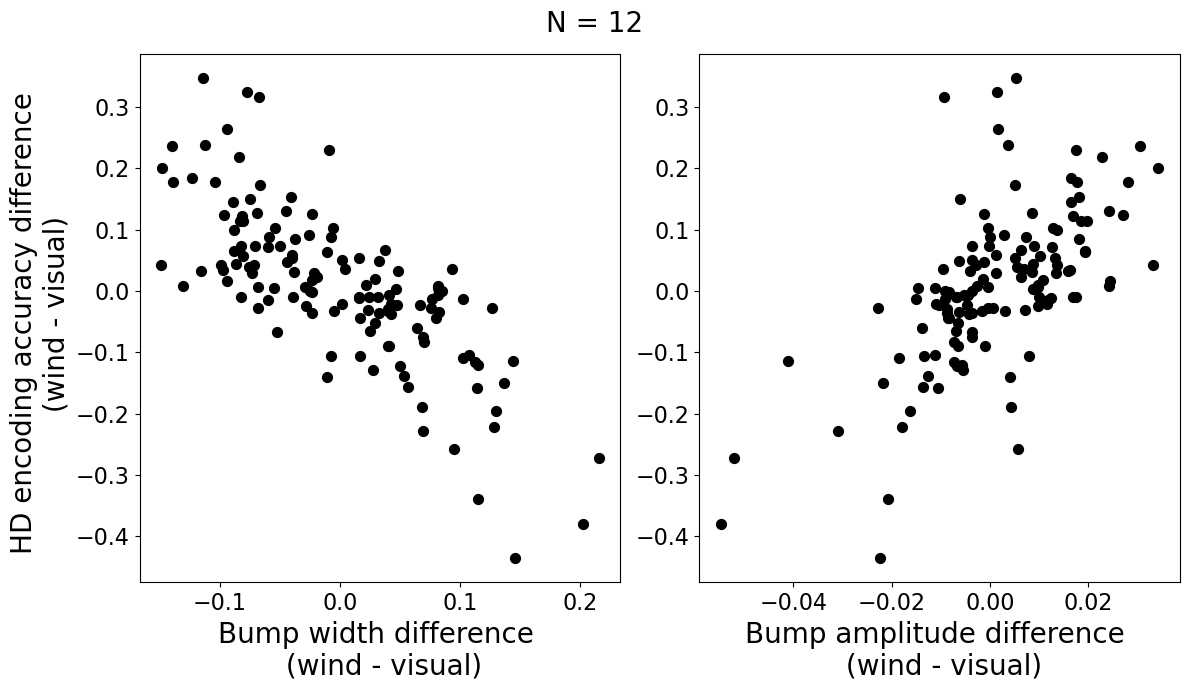

In [16]:
"""visualization - main figure"""

plot_fig4f = True

idx_wind_is_varied = np.argwhere(wind_is_varied)
idx_wind_is_varied = np.squeeze(idx_wind_is_varied)

idx_visual_is_varied = np.where(wind_is_varied == 0)
idx_visual_is_varied = idx_visual_is_varied[0]

if plot_fig4f:
    fig_4f, ax_4f = plt.subplots(1, 2, figsize=(12, 7))
    # fig_4f, ax_4f = plt.subplots(1, 2, figsize=(15, 7))

    fig_4f.suptitle(f'N = {n_sims}', fontsize=20)

    """black and white"""

    # bump width difference
    ax_4f[0].scatter(
        bump_width_diff, HD_encoding_accuracy_diff, color='k', s=50
    )

    # bump amplitude difference
    ax_4f[1].scatter(
        bump_amplitude_diff, HD_encoding_accuracy_diff, color='k', s=50
    )

    """use different colors for different ER amplitudes"""

    for i_param in range(n_params):
        color = plt.cm.viridis(i_param / n_params)

        """use one symbol"""
        
        # # bump width difference
        # ax_4f[0].scatter(
        #     bump_width_diff[:, i_param], 
        #     HD_encoding_accuracy_diff[:, i_param], 
        #     color=color, s=50
        # )

        # # bump amplitude difference
        # ax_4f[1].scatter(
        #     bump_amplitude_diff[:, i_param], 
        #     HD_encoding_accuracy_diff[:, i_param],
        #     color=color, s=50, label=f'ER amplitude = {ER_amplitude_varied_array[i_param] : .03f}'
        # )
        
        """use different symbols for fix visual, vary wind (square) vs. fix wind, vary visual (plus)"""

        # # bump width difference
        # ax_4f[0].scatter(
        #     bump_width_diff[idx_wind_is_varied, i_param], 
        #     HD_encoding_accuracy_diff[idx_wind_is_varied, i_param], 
        #     marker='s', color=color, s=50
        # )
        # ax_4f[0].scatter(
        #     bump_width_diff[idx_visual_is_varied, i_param], 
        #     HD_encoding_accuracy_diff[idx_visual_is_varied, i_param], 
        #     marker='+', color=color, s=50
        # )

        # # bump amplitude
        # ax_4f[1].scatter(
        #     bump_amplitude_diff[idx_wind_is_varied, i_param], 
        #     HD_encoding_accuracy_diff[idx_wind_is_varied, i_param],
        #     marker='s', color=color, s=50
        # )
        # ax_4f[1].scatter(
        #     bump_amplitude_diff[idx_visual_is_varied, i_param], 
        #     HD_encoding_accuracy_diff[idx_visual_is_varied, i_param],
        #     marker='+', color=color, s=50, label=f'ER amplitude = {ER_amplitude_varied_array[0, i_param] : .03f}'
        # )

    # ax_4f[1].legend(bbox_to_anchor=(1, 1), loc='upper left')

    ax_4f[0].set_xlabel('Bump width difference \n (wind - visual)')
    ax_4f[0].set_ylabel('HD encoding accuracy difference \n (wind - visual)')
    ax_4f[1].set_xlabel('Bump amplitude difference \n (wind - visual)')

    plt.tight_layout()

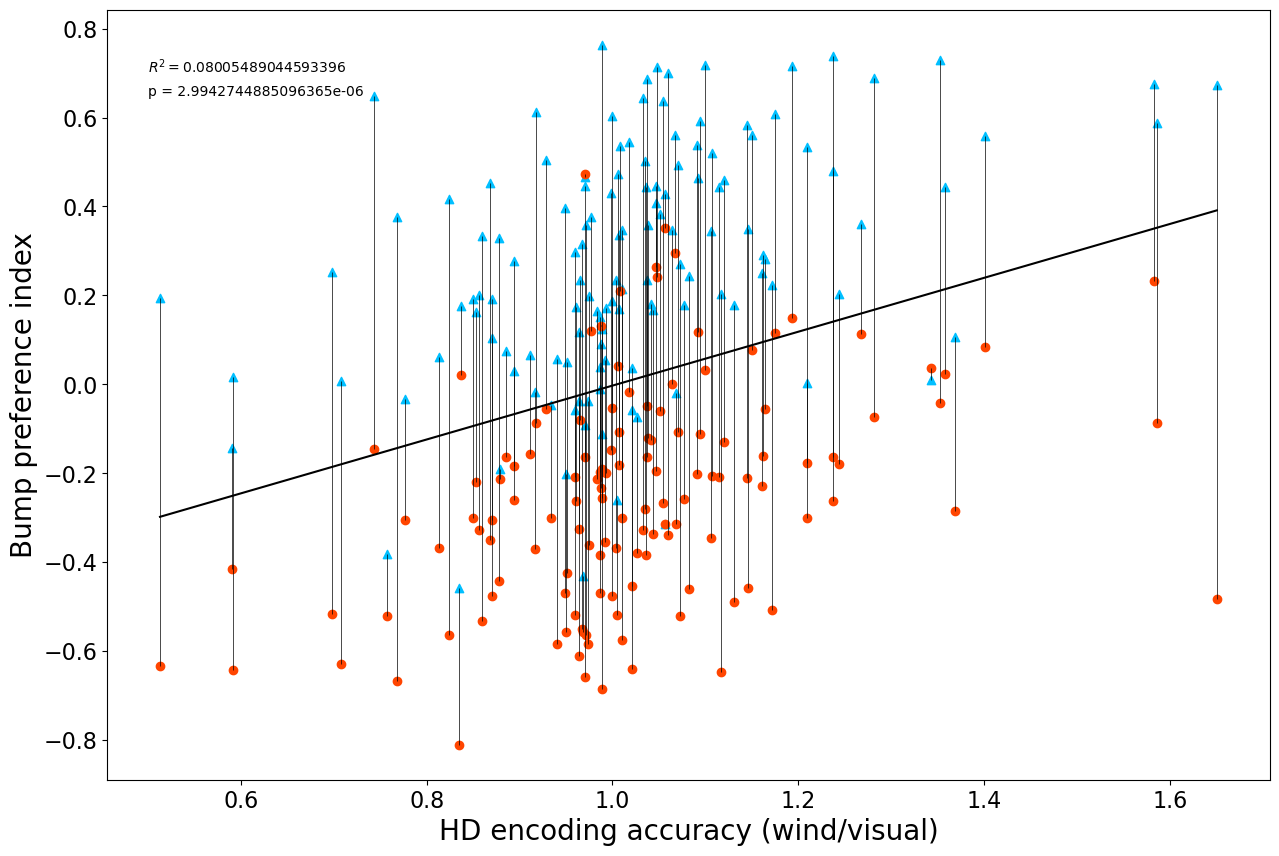

In [17]:
plot_fig4g = True

if plot_fig4g:
    fig_4g, ax_4g = plt.subplots(1, 1, figsize=(15, 10))

    # vertical lines connecting cue shifts from the same individual
    ax_4g.vlines(
        HD_encoding_accuracy_ratios,
        np.minimum(bump_pref_index_visual_shifts_mean, bump_pref_index_wind_shifts_mean),
        np.maximum(bump_pref_index_visual_shifts_mean, bump_pref_index_wind_shifts_mean),
        color='k', linewidth=0.5
    )

    # visual cue shifts
    ax_4g.scatter(
        HD_encoding_accuracy_ratios, bump_pref_index_visual_shifts_mean, 
        marker='^', color='deepskyblue'
    )

    # wind cue shifts
    ax_4g.scatter(
        HD_encoding_accuracy_ratios, bump_pref_index_wind_shifts_mean,
        marker='o', color='orangered'
    )

    # trend line
    ax_4g.plot(x_axis, linfit.slope * x_axis + linfit.intercept, color='k')
    ax_4g.annotate(f'$R^2 = {linfit.rvalue ** 2}$', (0.5, 0.7))
    ax_4g.annotate(f'p = {linfit.pvalue}', (0.5, 0.65))

    ax_4g.set_xlabel('HD encoding accuracy (wind/visual)')
    ax_4g.set_ylabel('Bump preference index')

In [18]:
"""save figure panels"""

if save_fig4f:
    fig_4f.savefig(os.path.join(save2path, filename_fig4f + '.' + fig_format), format=fig_format)

if save_fig4g:
    fig_4g.savefig(os.path.join(save2path, filename_fig4g + '.' + fig_format), format=fig_format)